<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/autoregressive_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive LSTM
We would like to forecast sequences of different length than those used to train a model. One approach, called autoregressive, is to use the forecast as input for the next forecast. For instance, we use one input sequence to make a forecast of a certain length, and then we use this same forecast as input to the model to make the next one.   

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import keras
from keras import layers
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
print('TensorFlow version: %s'%tf.__version__)
print('Keras version: %s'%keras.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.0
TensorFlow version: 2.18.0
Keras version: 3.8.0


In [2]:
def download_data(url):
  r = requests.get(url)
  data_path = url.rsplit('/')[-1]
  with open(data_path, 'wb') as f:
    f.write(r.content)
  return data_path

## Dataset and data window
We download the traffic datasets and define the data structure to build the batches of tensors for training, validation, and test.

In [3]:
train_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/train.csv'
val_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/val.csv'
test_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/test.csv'
train_data = download_data(train_url)
val_data = download_data(val_url)
test_data = download_data(test_url)
train_df = pd.read_csv(train_data, index_col=0)
val_df = pd.read_csv(val_data, index_col=0)
test_df = pd.read_csv(test_data, index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


## Dataset and data window
We define the data structure to build the batches of tensors for training, validation, and test.

In [4]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        '''
        This function separates inputs and labels from the features.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The function plots the model's predictions for three data windows
        '''
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        '''
        This function is based on a Keras function to create batches of data by sliding windows of inputs and lables from the train, validation, and test sets.
        The slide is set with the sequence_stride argument and it is set to 1. The data windows are shuffled but the order within each window is preserved.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

We use the mean square error as loss function, and the mean absolute error as the performance metric.

In [5]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  metrics=[keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

## The autoregressive LSTM model for multi-step forecast
The model is built on top of a [LSTM cell](https://keras.io/api/layers/recurrent_layers/lstm_cell/), to make single-step forecast, and a [RNN layer](https://keras.io/api/layers/recurrent_layers/rnn/) that is used as a wrapper of the LSTM cell. The single-step forecasts are stacked in a list to provide a forecast sequence of the requested length. In our example we want a forecast of 24 hours.

In [7]:
class AutoRegressive(keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = layers.LSTMCell(units)
        self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
        self.dense = layers.Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions


In [10]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)
history = compile_and_fit(AR_LSTM, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0830 - mean_absolute_error: 0.2280 - val_loss: 0.0191 - val_mean_absolute_error: 0.0983
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0167 - mean_absolute_error: 0.0910 - val_loss: 0.0166 - val_mean_absolute_error: 0.0881
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0151 - mean_absolute_error: 0.0846 - val_loss: 0.0159 - val_mean_absolute_error: 0.0865
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0146 - mean_absolute_error: 0.0824 - val_loss: 0.0158 - val_mean_absolute_error: 0.0864
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0144 - mean_absolute_error: 0.0817 - val_loss: 0.0156 - val_mean_absolute_error: 0.0840
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0141 - mean_absolute_error: 0.0804 - val_loss: 0.0154 - val_mean_absolute_error: 0.0841
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0140 - mean_absolute_error: 

In [11]:
AR_LSTM.summary()

Model: "auto_regressive_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_cell_1 (LSTMCell)               │ ?                           │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_1 (RNN)                          │ ((None, 32), (None, 32),    │           4,864 │
│                                      │ (None, 32))                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,089 (58.95 KB)

 Trainable params: 5,029 (19.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,060 (39.30 KB)

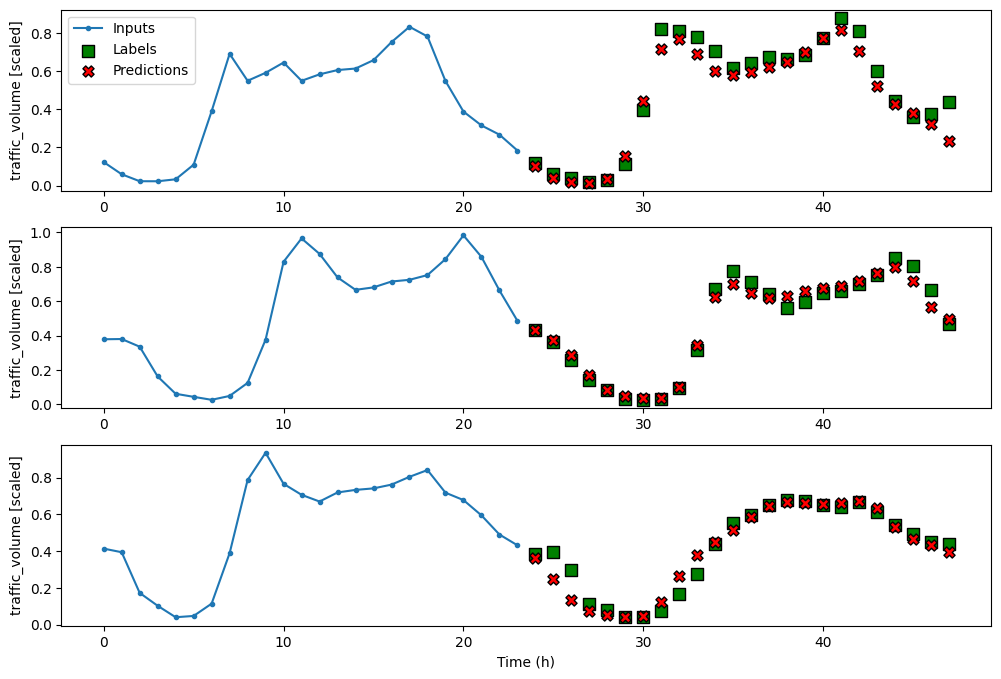

In [12]:
multi_window.plot(AR_LSTM)

In [21]:
ms_val_performance = {}
ms_performance = {}
ms_val_performance['AR-LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR-LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0673


We compare the performance of the autoregressive LSTM for multi-step forecasts with the performances of previous models

In [22]:
ms_mae_val = [0.088, 0.078, 0.070, 0.078, 0.069]
ms_mae_test = [0.076, 0.064, 0.058, 0.063, 0.055]
ms_mae_val.append(ms_val_performance['AR-LSTM'][1])
ms_mae_test.append(ms_performance['AR-LSTM'][1])

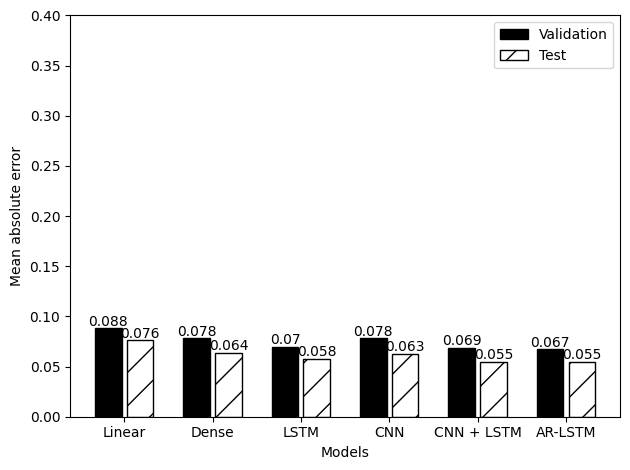

In [23]:
x = np.arange(6)

labels = ['Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR-LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()